# Individual contact matrices from activities
The objective in this part is to obtain, at least for a sample of the population, the number of daily contacts with other individuals. The contacts are split into groups depending on the type of activity in which the contact happened, as well as the age of the target person.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import sklearn
import os
from tqdm.notebook import tqdm
from time import time
from datetime import datetime
from collections import defaultdict
from time import time
from itertools import product

sns.set_context("notebook")

## Loading data
The dataframe ```data/matsim_population_activities.csv``` contains the list of all activities for each individual based on the MATSIM simulation.

In [ ]:
activities_df = pd.read_csv('../data/matsim_population_activities.csv')
activities_df.head(10)

Let's have a look at how many unique values each column contains:

In [ ]:
unique_values_counts = pd.Series({col: activities_df[col].drop_duplicates().shape[0] for col in activities_df.columns})
sns.barplot(x=unique_values_counts.index, y=unique_values_counts.values, log=True)
plt.title('Number of unique values')
plt.show()

In [ ]:
# We'll need to remove the rows in which the facility is null
activities_df = activities_df[activities_df['facility'].notna()]

We won't use the ```link```, ```x``` and ```y``` columns:

In [ ]:
activities_df = activities_df.drop(['link', 'x', 'y'], axis=1)

## Adding age

In [ ]:
population_data = pd.read_csv('../data/matsim_population_attributes.csv')
population_data.head()

In [ ]:
# Fetches the id-age association
id_age_df = population_data[['id', 'age']].drop_duplicates().set_index('id')
id_age_df.index.is_unique

In [ ]:
activities_df = activities_df.merge(id_age_df, left_on="id", right_index=True)
activities_df.sample(10)

In [ ]:
age_intervals = pd.DataFrame({'From': [0, 10, 20, 36, 51, 65], 'To': [9, 19, 35, 50, 64, 150], 'Group':['0-9', '10-19', '20-35', '36-50', '51-64', '65-']})
age_intervals

In [ ]:
# Converts to pandas IntervalIndex objects which will automatically be mapped to the age column
age_intervals = age_intervals.set_index(pd.IntervalIndex.from_arrays(age_intervals['From'], 
                                                             age_intervals['To'], closed="both"))['Group']

activities_df['age_group'] = activities_df['age'].map(age_intervals)
activities_df.sample(10)

In [ ]:
activities_df = activities_df.drop('age', axis=1)

## Pre-processing the activity starting / ending times
Some activities do not have a starting time or an ending time (NaN), to indicate that they haven't started or ended at any point during the day. This is usually the case for the first "home" activity of the day for example.  
We'll thus replace these NaNs by 00:00 for the starting times and 23:59 for the ending times. Note that we'll also discard the seconds.

In [ ]:
activities_df['start_time'] = activities_df['start_time'].fillna('00:00:00')
activities_df['end_time'] = activities_df['end_time'].fillna('23:59:59')

We also need to convert the times from strings to datetimes:

In [ ]:
activities_df['start_time'] = pd.to_datetime(activities_df['start_time'], format="%H:%M:%S", errors="coerce")
activities_df['end_time'] = pd.to_datetime(activities_df['end_time'], format="%H:%M:%S", errors="coerce")
# Some start / end times are beyond 24h. They were convert to "NaT".
# For those, we'll replace them with 00:00 and 23:59 respectively
activities_df['start_time'] = activities_df['start_time'].fillna(pd.Timestamp(year=1900, month=1, day=1))
activities_df['end_time'] = activities_df['end_time'].fillna(pd.Timestamp(year=1900, month=1, day=1, hour=23, minute=59))

We can now convert the exact timestamps to time periods, for example an hour or 30 minutes. Shorter periods will yield more precise contacts
but take longer to process.

In [ ]:
# Use 'H' for an hour or '30T' for 30 minutes.
_TIME_PERIOD_ = 'H'
activities_df['start_time'] = activities_df['start_time'].dt.floor(_TIME_PERIOD_)
activities_df['end_time'] = activities_df['end_time'].dt.floor(_TIME_PERIOD_)

## Building the contacts dataframe
We'll now need to obtain the information for each time period, for example ("Where was indiv $i$ at period $t$ ?"). For now the periods are aggregated: we know "$i$ was at $f$ between $t_a$ and $t_b$".  

### Exploding the periods

We can now explode the dataset according to the period:

In [ ]:
# Explodes the dataframe based on the time period. For example an activity starting at 10:00 and ending 10:30, with a
# period of 10 min, will result in 3 identical rows (one for 10:00, for 10:10, and 10:20).
# The resulting dataframe can be MUCH larger if the time period is especially short (such as 1 or 5 min).

# The following creates a columns whose values are lists of periods from start_time to end_time
activities_df['period'] = activities_df.apply(lambda row: pd.date_range(row['start_time'], row['end_time'], freq=_TIME_PERIOD_), axis=1)
# We can now drop the start_time and end_times columns (and we should to avoid multiplying the rows after exploding !)
activities_df = activities_df.drop(['start_time', 'end_time'], axis=1)
# This explodes the dataset with regards to the lists just created
activities_df = activities_df.explode('period')
activities_df.head(10)

Let's see how many rows we obtain:

In [ ]:
activities_df.shape

In [ ]:
activities_df.to_csv('../data/activities_df.csv')

## Computing contacts
Computing contacts is fairly difficult, as we cannot just sample the population to make it quicker. If we did that, we'd actually reduce the number of contacts encountered as we would miss all contacts with individuals who were not sampled.  
What we can do is: for every indiv $i$ in a sample $S$ of the population, compute ALL contact of $i$, even with people that are not in $S$.  

How to ?   
The main point will be to sort the activities dataframe by facility and period first, so that we can group together all contacts that happen at the same place at the same time.
* Sort the activities dataframe by facility and then period
* Browse the activities df:
    * Keep track of the current facility and period. 
    * Keep track of the IDs of all people $I$ who were at the current facility during the current period.
    * Once the facility or the period changes, we know we won't ever encounter that (facility, period) pair again since
      the DF is sorted. Then, for all individuals of $I$ that were sampled in $S$, account for the contacts that happened that the
      facility during that period.

In [ ]:
activities_df = pd.read_csv('../data/activities_df.csv')

Let's check the RAM usage of the dataframe:

In [ ]:
# Size of the DF in Gigabytes
activities_df.memory_usage().sum() / 1024 ** 3

In [ ]:
activities_df = activities_df.sort_values(['facility', 'period', 'age_group'])

In [ ]:
activities_df.head(10)

In [ ]:
activity_types = ['education', 'home', 'leisure', 'service', 'shop', 'work']
age_groups = activities_df['age_group'].drop_duplicates().sort_values().values
id_age_df = activities_df[['id', 'age_group']].drop_duplicates().set_index('id')

### Sampling ids

In [ ]:
sampled_ids = activities_df['id'].drop_duplicates().sample(frac=0.05)
sampled_ids_set = set(sampled_ids)

### Contacts for the sampled inviduals

In [ ]:
# The following variable will keep track of the current period, facility that are being
# looked at
current_facility = activities_df.loc[0, 'facility']
current_type = activities_df.loc[0, 'type']
current_period = activities_df.loc[0, 'period']
current_ids = []
# previous_contacts[id_A] will be the set of all other indivs that A has already been in contact
# with, so that we don't count them twice.
previous_contacts = {indiv_id:set([indiv_id]) for indiv_id in id_age_df.index}
# The result: contacts[act_type, age_group] is a dict D such that D[indiv] is the number of contacts of the individual
# in the corresponding age group and activity type
contacts = {(act_type, age_group): defaultdict(int) for act_type, age_group in product(activity_types, age_groups)}

start_time = time()

for cnt, row in enumerate(activities_df.itertuples()):
    # If the facility or the period changed, browsed all IDs that were in that
    # facility at that period. For all those that are inside the sample, compute
    # their contact at the facility during that period.
    if row.facility != current_facility or row.period != current_period:
        for indiv_id in current_ids:
            if indiv_id in sampled_ids_set:
                for contact_id in current_ids:
                    # Make sure we haven't seen this contact just yet
                    if contact_id not in previous_contacts[indiv_id]:
                        contact_age = id_age_df.loc[contact_id][0]
                        contacts[(current_type, contact_age)][indiv_id] += 1
                        previous_contacts[indiv_id].add(contact_id)
        current_facility = row.facility
        current_type = row.type
        current_ids = []
        current_period = row.period
    # Append the id just seen to the list of those present at the current facility
    # during the current period
    current_ids.append(row.id)
    if cnt % 1000000 == 0:
        print(f"{cnt} / {activities_df.shape[0]} in {time() - start_time:1.2f} sec")

# We need to do the counting operation one last time to account for the last
# (facility, period) couple
for indiv_id in current_ids:
    if indiv_id in sampled_ids_set:
        for contact_id in current_ids:
            if contact_id not in previous_contacts[indiv_id]:
                contact_age = id_age_df.loc[contact_id][0]
                contacts[(current_type, contact_age)][indiv_id] += 1
                previous_contacts[indiv_id].add(contact_id)

In [ ]:
contact_counts = pd.DataFrame(contacts)
print(contact_counts.shape)

In [ ]:
contact_counts.head()

In [ ]:
contact_counts = contact_counts.fillna(0)

### Saving the data

In [ ]:
# Multiindex column names are not well supported in the CSV format
# so we flatten them before saving the csv
contact_counts.columns = ['_'.join(col).strip() for col in contact_counts.columns.values]

In [ ]:
contact_counts.to_csv('../data/contact_counts.csv')

### Average contact matrix

In [77]:
contact_counts.shape

(103968, 36)

In [78]:
contact_counts.mean(axis=0)

education_0-9      1.098973
education_10-19    4.613468
education_20-35    3.944983
education_36-50    1.101252
education_51-64    0.772555
education_65-      0.439270
home_0-9           0.297255
home_10-19         0.328755
home_20-35         0.421716
home_36-50         0.525998
home_51-64         0.310980
home_65-           0.200850
leisure_0-9        0.753549
leisure_10-19      1.857264
leisure_20-35      3.236659
leisure_36-50      3.227320
leisure_51-64      2.597290
leisure_65-        3.266380
service_0-9        0.019843
service_10-19      0.064741
service_20-35      0.236361
service_36-50      0.272266
service_51-64      0.208468
service_65-        0.130886
shop_0-9           0.067569
shop_10-19         0.198340
shop_20-35         0.708487
shop_36-50         0.962873
shop_51-64         0.810047
shop_65-           1.106850
work_0-9           0.013648
work_10-19         1.148392
work_20-35         8.432460
work_36-50         9.054786
work_51-64         6.496951
work_65-           0

# Predicting contacts from socio-economic factors
Now that we have the contact matrices for a sample of the population, identified via the IDs, we can build a model to estimate these matrices based on the socio-economic factors that are available for these people.

## Loading the socio-economic data

In [1]:
%matplotlib inline
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.preprocessing import StandardScaler
sns.set_context("notebook")

/home/clement/.conda/envs/covid/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# Loads the socio-eco data
wave = 1
soc_eco_df = pd.read_csv(f'../data/soc_eco_df_infected_muni_wave{wave}.csv', index_col="id")
soc_eco_df.head()

<ipython-input-2-dec9aa908d3f>:3: DtypeWarning: Columns (48,49,52,53,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  soc_eco_df = pd.read_csv(f'../data/soc_eco_df_infected_muni_wave{wave}.csv', index_col="id")


,Unnamed: 0.1,Unnamed: 0,age,bikeAvailability,carAvail,employed,hasLicense,home_x,home_y,householdIncome,...,PEV/PCS,PVL,PBD,PST,PES,SmallRightParties,rich,poor,female,interactemployed_poor
id,,,,,,,,,,,,,,,,,,,,,
17639,0,137601,54.0,FOR_ALL,always,1,yes,2678057.0,1240960.0,18000.0,...,4.194018,16.237935,1.28403,0.176013,12.368531,1.385022,1,0,1,1
14698,1,137076,50.0,FOR_ALL,always,1,yes,2677809.0,1241089.0,16000.0,...,4.194018,16.237935,1.28403,0.176013,12.368531,1.385022,1,0,1,1
14703,2,137081,46.0,FOR_ALL,always,1,yes,2677660.0,1240972.0,18000.0,...,4.194018,16.237935,1.28403,0.176013,12.368531,1.385022,1,0,1,1
14708,3,137082,33.0,FOR_ALL,always,1,yes,2678099.0,1241037.0,10000.0,...,4.194018,16.237935,1.28403,0.176013,12.368531,1.385022,1,0,1,1
14719,4,137085,67.0,FOR_ALL,always,0,yes,2677672.0,1241175.0,4000.0,...,4.194018,16.237935,1.28403,0.176013,12.368531,1.385022,0,1,1,1


### Checking the data types

A warning tells us that some columns have mixed data types:

In [3]:
wrong_cols_names = ['TotalEmplois', 'Employement1Sector', 'TotalEtablissement',
       'Etablissement1Sector', 'PBD', 'PST']

In [4]:
# Let's have a look at all values that appear in column 52
pd.unique(soc_eco_df.iloc[:, 52])

array(['14', '21', '24', 'X', '23', '17', '6', 6, 5, 8, '8', '7', '52',
       52, 66, '66', '39', '16', '11', '10', '35', '5', 15, 13, 0, 22, 24,
       16, 17, 4, 37, 11, 10, 44, 7, 36, 31, 9, 14, 28, 40, 23, '29',
       '27', '25', 21, 27, 12, 18, '13', '12', '45', '33', '19', '26',
       '9', '30', '31', '15', '20', '34', '48', '88', '18', '53', '4',
       '40'], dtype=object)

It appears that some entries are entered as strings but actually contain an integer. Some entries also contain characters like * or X which most likely indicate
missing values.  
The following tries to convert the values to integers, and replace them with NaNs otherwise.

In [5]:
def string_int_to_int(string_int):
    """
    Converts an integer contained in a string into a real integer.
    If the conversion fails, returns NA.
    """
    try:
        res = int(string_int)
        return res
    except ValueError:
        return np.nan

In [6]:
# apply the function to each problematic column
for col in wrong_cols_names:
    soc_eco_df[col] = soc_eco_df[col].apply(string_int_to_int)

The question is, can we remove the resulting NaN values ? We first need to check how many rows include NaNs:

In [7]:
uncomplete_rows = soc_eco_df[soc_eco_df.isna().any(axis=1)]
uncomplete_rows

,Unnamed: 0.1,Unnamed: 0,age,bikeAvailability,carAvail,employed,hasLicense,home_x,home_y,householdIncome,...,PEV/PCS,PVL,PBD,PST,PES,SmallRightParties,rich,poor,female,interactemployed_poor
id,,,,,,,,,,,,,,,,,,,,,
123691,7898,130800,59.0,FOR_ALL,always,1,yes,2689192.0,1253853.0,2000.0,...,2.814337,16.190208,2.0,0.0,8.570329,1.881653,0,1,1,1
123347,7899,130723,62.0,FOR_NONE,always,1,yes,2688614.0,1253197.0,16000.0,...,2.814337,16.190208,2.0,0.0,8.570329,1.881653,1,0,0,1
122625,7900,130588,61.0,FOR_ALL,sometimes,0,yes,2688681.0,1252235.0,8000.0,...,2.814337,16.190208,2.0,0.0,8.570329,1.881653,1,0,1,0
122642,7901,130590,20.0,FOR_SOME,sometimes,0,no,2688914.0,1252826.0,12000.0,...,2.814337,16.190208,2.0,0.0,8.570329,1.881653,1,0,1,0
122643,7902,130591,26.0,FOR_SOME,always,0,yes,2688914.0,1252826.0,12000.0,...,2.814337,16.190208,2.0,0.0,8.570329,1.881653,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295887,270051,292228,50.0,FOR_ALL,always,1,yes,2658652.0,1272284.0,6000.0,...,1.194722,3.914051,2.0,NaN,5.786377,0.436876,0,0,0,1
2295907,270052,292232,69.0,FOR_NONE,always,0,yes,2658735.0,1270248.0,10000.0,...,1.194722,3.914051,2.0,NaN,5.786377,0.436876,1,0,0,0
2295911,270053,292235,49.0,FOR_ALL,always,1,yes,2657384.0,1269639.0,10000.0,...,1.194722,3.914051,2.0,NaN,5.786377,0.436876,1,0,0,1


In [8]:
len(soc_eco_df)

270056

It appears that 152,000 rows out of 270,000 contain NaN values. Thus it would be very costly to remove them as it would reduce the amount of data available but also potentially create biases linked to how the missing values were distributed. Thus it is safer to just remove the problematic columns.

In [9]:
soc_eco_df = soc_eco_df.drop(wrong_cols_names, axis=1)

No null values are left in the dataset and the dtypes seem in order.


### Column names
Some columns need to be renamed to avoid confusions or remove special characters, such as in 'PopDensityPer_km²':

In [10]:
soc_eco_df = soc_eco_df.rename({'PopDensitiyPer_km²':'PopDensity', 'TotSurfacePer_km²':'TotSurface'}, axis=1)

### Useless columns
The first two columns are linked to the way the data was created but are no longer of any use, so we might as well remove them. The "female" column is also redundant with the "sex" column, so we'll remove it.

In [11]:
soc_eco_df = soc_eco_df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'sex'], axis=1)

## Preprocessing

### Checking for null values

In [12]:
na_cols_counts = soc_eco_df.isna().sum()
print(na_cols_counts[na_cols_counts > 0])

SocialSecurityRate    1147
dtype: int64


The "SocialSecurityRate" variable is missing for 1147 people. Out of of 270k it might seem like we could discard them, but this could induce a bias in the data..  
For now, we'll discard the entire column (so we won't use that feature for any prediction), however a better method in the future is to predict the missing values based on the other variables.

In [13]:
soc_eco_df = soc_eco_df.drop('SocialSecurityRate', axis=1)

### Discarding the geographical features
The data includes some variables that give geographical information about the individuals. This information is necessarily correlated with the
infections as those were introduced into the synthetic population based on the incidence in every *municipality*.

Thus we cannot include those features in the models if we want to search for a relationship between the other features and infections.

In [14]:
geographical_features = ['home_x', 'home_y', 'Lat', 'Lon', 'lat_lon', 'postcode', 'MuniZIP', 'MuniZIP_x', 'MuniZIP_y',]
geo_features_df = soc_eco_df[geographical_features]
soc_eco_df = soc_eco_df.drop(geographical_features, axis=1)

**Note**: another possibility than discarding those features would be to use a spatial linear model, such as Geographically Weighted Regressions (GWR) or Spatial Lag Models (SLM).

### Converting categorical features to one-hot

In [15]:
# Selects the columns whose values are categorical
categorical_features = soc_eco_df.select_dtypes('object')
categorical_features.head()

,bikeAvailability,carAvail,hasLicense,municipalityType,ov_guteklasse
id,,,,,
17639,FOR_ALL,always,yes,urban,D
14698,FOR_ALL,always,yes,urban,D
14703,FOR_ALL,always,yes,urban,D
14708,FOR_ALL,always,yes,urban,D
14719,FOR_ALL,always,yes,urban,C


The "hasLicense" feature is binary, so we'll just replace yes/no with 1/0:

In [16]:
soc_eco_df['hasLicense'] = soc_eco_df['hasLicense'].apply(lambda val: 1 if val == "yes" else 0)
categorical_features.drop('hasLicense', axis=1, inplace=True)

In [17]:
categorical_features_onehot = pd.get_dummies(categorical_features)
# Let's have a look at all possible values that we obtain for those features
categorical_features_onehot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270056 entries, 17639 to 2295843
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype
---  ------                     --------------   -----
 0   bikeAvailability_FOR_ALL   270056 non-null  uint8
 1   bikeAvailability_FOR_NONE  270056 non-null  uint8
 2   bikeAvailability_FOR_SOME  270056 non-null  uint8
 3   carAvail_always            270056 non-null  uint8
 4   carAvail_never             270056 non-null  uint8
 5   carAvail_sometimes         270056 non-null  uint8
 6   municipalityType_rural     270056 non-null  uint8
 7   municipalityType_suburban  270056 non-null  uint8
 8   municipalityType_urban     270056 non-null  uint8
 9   ov_guteklasse_A            270056 non-null  uint8
 10  ov_guteklasse_B            270056 non-null  uint8
 11  ov_guteklasse_C            270056 non-null  uint8
 12  ov_guteklasse_D            270056 non-null  uint8
dtypes: uint8(13)
memory usage: 5.4 MB


In [18]:
# Replaces the original categorical features in the full dataset with their one-hot versions
# we just computed:
soc_eco_df = soc_eco_df.drop(categorical_features.columns, axis=1)
soc_eco_df = pd.concat([soc_eco_df, categorical_features_onehot], axis=1)

We obtain a dataset ready to be used for statistical analysis.

## Statistical Analysis

### Contact - soc/eco factors relationship
Here we hope to predict the contact matrices of an individual based on their socio-economic position.  
The first test we'll perform is an ordinary least-squares linear regression with only a few features as input:  
age, sex, Pop65, Pop20, PopDulation density  
Except for the 'female' feature which is binary, we'll use the log of the variables so that their distribution is less skewed.

In [108]:
# Drops the 'infected' column as this isn't our predicted variable here
infected = soc_eco_df['infected']
soc_eco_df = soc_eco_df.drop('infected', axis=1)
soc_eco_data = soc_eco_df

### PCA of soc-eco factors
We'll use a PCA to try to distinguish potential clusters in the data:

In [20]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

In [21]:
# Performs PCA onto the soc/eco features to reduce them to 2d
soc_eco_pca = PCA(n_components=5, random_state=42)
soc_eco_scaler = StandardScaler()
soc_eco_scaler.fit(soc_eco_data)
scaled_soc_eco_data = soc_eco_scaler.transform(soc_eco_data)

soc_eco_pca.fit(scaled_soc_eco_data)
pca_transform = soc_eco_pca.transform(scaled_soc_eco_data)

# Applies GMM clustering to better visualize the clusters and use
# them for further analysis
pca_gmm = GaussianMixture(n_components=2, random_state=42).fit(pca_transform)
pca_clusters = pca_gmm.predict(pca_transform)

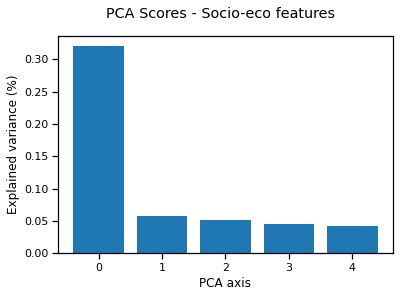

In [22]:
# Prints the explained variance for each component
plt.bar(x=np.arange(soc_eco_pca.components_.shape[0]), height=soc_eco_pca.explained_variance_ratio_)
plt.xlabel('PCA axis')
plt.ylabel('Explained variance (%)')
plt.suptitle("PCA Scores - Socio-eco features")
plt.savefig("../figures/pca_soc_eco_variance.png")
plt.show()

Given that axis 0 explains a lot more of the total variance than the following axes, we can expect the data to be clustered along this single dimension.  
We can visualize the first two axes to hope to see those clusters:

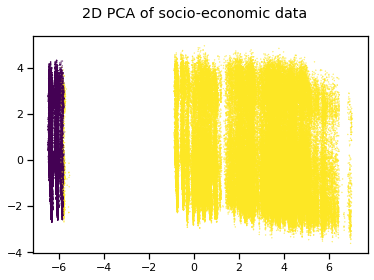

In [23]:
plt.scatter(pca_transform[:, 0], pca_transform[:, 1], c=pca_clusters, s=0.1)
plt.suptitle("2D PCA of socio-economic data")
plt.savefig("../figures/pca_soc_eco_2d.png")
plt.show()

There are two clear clusters isolated by axis 0. Let's have a look at the important features:

In [24]:
def pca_features_ranking(fitted_pca, feature_names, pca_axis=0):
    """
    Given a PCA axis, returns the coefficient of each feature
    in that axis, ranked by importance.
    """
    features_ranking_indices = np.argsort(np.abs(fitted_pca.components_[pca_axis]))[::-1]
    features_ranking = pd.Series({feature: coef
                    for feature, coef in zip(feature_names[features_ranking_indices],
                                             fitted_pca.components_[0][features_ranking_indices])
                   }, name=f"PCA axis {pca_axis} coefs").rename_axis('Feature coef')
    return features_ranking

In [25]:
pca_features_ranking(soc_eco_pca, soc_eco_data.columns.values).head(15)

Feature coef
Employement2Sector                 -0.219605
Etablissement2Sector               -0.217820
NbrResident                        -0.216271
PrivateHouseholds                  -0.216262
Employement3Sector                 -0.216014
PopDensity                         -0.215896
Etablissement3Sector               -0.215644
TotSurface                         -0.215449
HabInfraSurface_VariationHa        -0.210219
PES                                -0.208413
AgriSurface_VariationHa             0.207528
Pop20                              -0.200139
MeanSizeHouseholdsPerPerson         0.194639
HabitationInfrastructureSurface%   -0.194297
UDC                                 0.190458
Name: PCA axis 0 coefs, dtype: float64

Clearly the most important features are those related to the **municipality** (variables that are equal for all individuals living within the same muni).  
We thus need to have a look at the distribution of municipalities:

In [26]:
muni_populations = geo_features_df['MuniZIP'].value_counts().sort_values(ascending=False)
print(f"Found {muni_populations.shape[0]} unique munis")

Found 138 unique munis


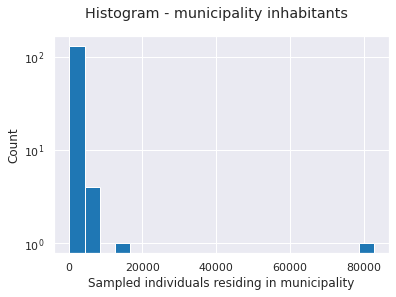

In [121]:
with sns.axes_style('darkgrid'):
    plt.hist(muni_populations.values, bins=20, log=True)
    plt.suptitle('Histogram - municipality inhabitants')
    plt.xlabel('Sampled individuals residing in municipality')
    plt.ylabel('Count')
    plt.savefig("../figures/munis_pop_hist.png")
    plt.show()

In [28]:
muni_populations.head()

261     82728
3203    16339
243      6038
4001     4652
62       4457
Name: MuniZIP, dtype: int64

While the large majority of munis include less than 10K residents in the sample, two municipalities include respectively 16k and 82k residents.  Let's examine their postcodes so that we can know which cities those are:

In [29]:
zip_postcode_pairs = geo_features_df[['MuniZIP', 'postcode']].drop_duplicates('MuniZIP')
zip_postcode_pairs[zip_postcode_pairs['MuniZIP'].isin([261, 3203])]

,MuniZIP,postcode
id,,
1471057,261,8004
2322350,3203,9000


Quite expectedly, the two major cities are **Zürich** (postcodes 8000) and **St-Gallens** (postcodes 9000).  
Let's verify that the clusters indeed separate residents from Zürich from the rest of the population:

In [30]:
# Creates a column indicating if individuals live in Zurich, St-Gallens or some other muni
munis_cluster_ids = {261: 0, 3203: 1}
def map_muniZIP_cluster_id(muniZIP):
    if muniZIP in munis_cluster_ids:
        return munis_cluster_ids[muniZIP]
    else:
        return 2

zurich_indicator = pd.to_numeric(geo_features_df['MuniZIP'].apply(map_muniZIP_cluster_id))

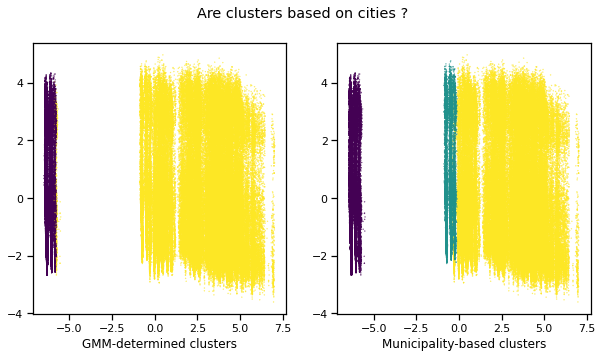

In [31]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(pca_transform[:, 0], pca_transform[:, 1], c=pca_clusters, s=0.1)
plt.xlabel("GMM-determined clusters")
plt.subplot(122)
plt.scatter(pca_transform[:, 0], pca_transform[:, 1], c=zurich_indicator, s=0.1)
plt.xlabel("Municipality-based clusters")
plt.suptitle("Are clusters based on cities ?")
plt.savefig("../figures/pca_cities.png")
plt.show()

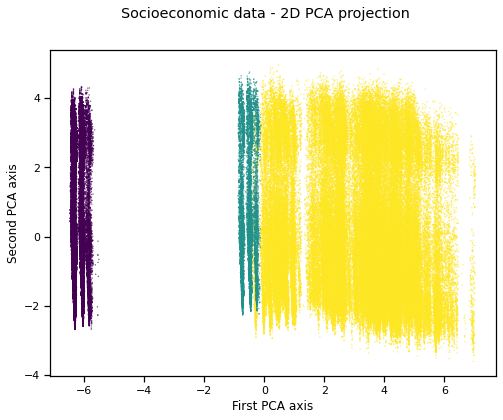

In [81]:
plt.figure(figsize=(8, 6))
plt.scatter(pca_transform[:, 0], pca_transform[:, 1], c=zurich_indicator, s=0.1)
plt.xlabel("First PCA axis")
plt.ylabel("Second PCA axis")
plt.suptitle('Socioeconomic data - 2D PCA projection')
plt.savefig("../figures/pca_cities_labeled.png")
plt.show()

**Conclusion**:  

The boolean variable "Lives in Zürich", which is not event present in the features, makes by far the most difference between the individuals.

### Loading contacts

In [32]:
# Loads the contacts dataframe
contacts_df = pd.read_csv('../data/contact_counts.csv', index_col=0)
contacts_data = contacts_df
contacts_df.head()

,education_0-9,education_10-19,education_20-35,education_36-50,education_51-64,education_65-,home_0-9,home_10-19,home_20-35,home_36-50,...,shop_20-35,shop_36-50,shop_51-64,shop_65-,work_0-9,work_10-19,work_20-35,work_36-50,work_51-64,work_65-
4396684,5.0,40.0,20.0,13.0,11.0,2.0,0.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3351597,5.0,41.0,19.0,13.0,11.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3525328,2.0,41.0,19.0,11.0,9.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
4191085,5.0,41.0,20.0,12.0,11.0,2.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4134855,5.0,41.0,20.0,12.0,10.0,2.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### PCA of contact matrices
We'll now study the distribution of contact matrices, perhaps to discover similar clusters as within the socio-economic data.

In [33]:
# Performs PCA onto the soc/eco features to reduce them to 2d
contacts_pca = PCA(n_components=5, random_state=42)
contacts_scaler = StandardScaler()
contacts_scaler.fit(contacts_data)
scaled_contacts_data = contacts_scaler.transform(contacts_data)

contacts_pca.fit(scaled_contacts_data)
pca_contacts_transform = contacts_pca.transform(scaled_contacts_data)

# Applies GMM clustering to better visualize the clusters and use
# them for further analysis
pca_contacts_gmm = GaussianMixture(n_components=3, random_state=42).fit(pca_contacts_transform)
pca_contacts_clusters = pca_contacts_gmm.predict(pca_contacts_transform)

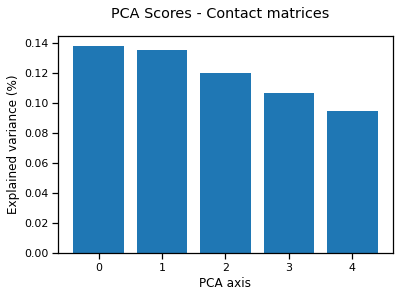

In [34]:
# Prints the explained variance for each component
plt.bar(x=np.arange(contacts_pca.components_.shape[0]), height=contacts_pca.explained_variance_ratio_)
plt.xlabel('PCA axis')
plt.ylabel('Explained variance (%)')
plt.suptitle("PCA Scores - Contact matrices")
plt.savefig("../figures/pca_contacts_variance.png")
plt.show()

This time, the first two clusters explain a similar portion of the variance. We can thus hope for the data to be clustered in a 2D projection:

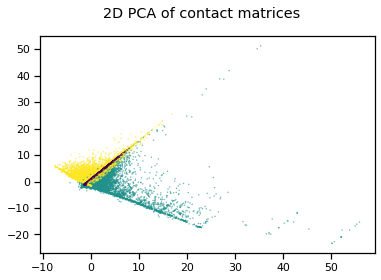

In [35]:
plt.scatter(pca_contacts_transform[:, 0], pca_contacts_transform[:, 1], c=pca_contacts_clusters, s=0.1)
plt.suptitle("2D PCA of contact matrices")
plt.savefig("../figures/pca_contacts_2d.png")
plt.show()

### Merging the dataframes - creating X and Y
We'll now merge the contacts dataframe (which gives for a sample of the population the contact matrices) and the socio-economics dataframe.  
We then hope to predict the former based on the latter.  
Naturally we need a sufficient amount of individuals to be present in both datasets so that the merged one contains enough values to perform
a meaningful analysis.

The following three cells prepare sub-dataframes ```X``` and ```y``` for feature selection and ML tasks:

In [109]:
merged_df = soc_eco_df.merge(contacts_df, left_index=True, right_index=True)
merged_df.shape

(13536, 97)

In [110]:
merged_df.to_csv('../data/merged_df.csv')

In [111]:
X = merged_df[soc_eco_df.columns].astype(np.float64)
print(X.shape, X.dtypes)

(13536, 61) age                       float64
employed                  float64
hasLicense                float64
householdIncome           float64
isCarPassenger            float64
                           ...   
municipalityType_urban    float64
ov_guteklasse_A           float64
ov_guteklasse_B           float64
ov_guteklasse_C           float64
ov_guteklasse_D           float64
Length: 61, dtype: object


In [112]:
y = merged_df[contacts_df.columns]
print(y.shape, y.dtypes)

(13536, 36) education_0-9      float64
education_10-19    float64
education_20-35    float64
education_36-50    float64
education_51-64    float64
education_65-      float64
home_0-9           float64
home_10-19         float64
home_20-35         float64
home_36-50         float64
home_51-64         float64
home_65-           float64
leisure_0-9        float64
leisure_10-19      float64
leisure_20-35      float64
leisure_36-50      float64
leisure_51-64      float64
leisure_65-        float64
service_0-9        float64
service_10-19      float64
service_20-35      float64
service_36-50      float64
service_51-64      float64
service_65-        float64
shop_0-9           float64
shop_10-19         float64
shop_20-35         float64
shop_36-50         float64
shop_51-64         float64
shop_65-           float64
work_0-9           float64
work_10-19         float64
work_20-35         float64
work_36-50         float64
work_51-64         float64
work_65-           float64
dtype: object


#### Distributions of the features

<ipython-input-113-54a52c9e16c3>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  X.hist(ax=ax, bins=20)


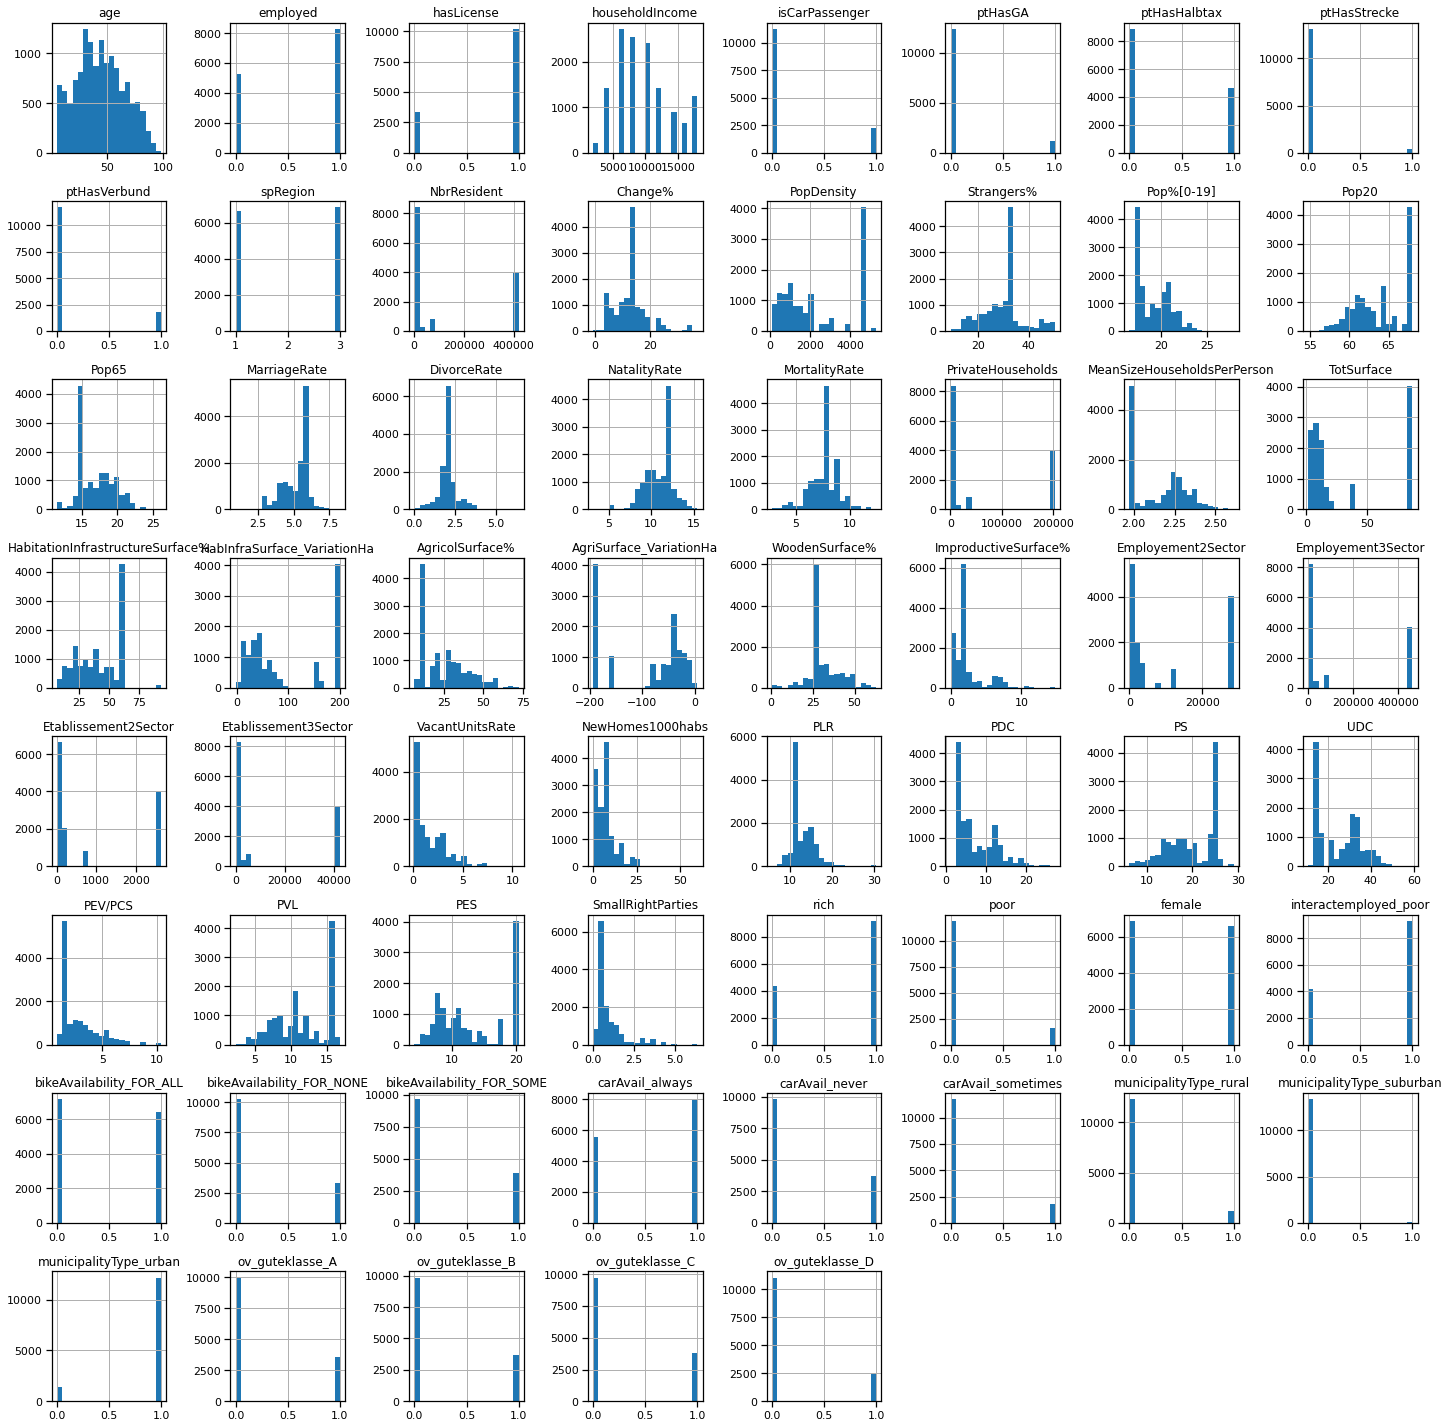

In [113]:
fig = plt.figure(figsize=(20, 20), tight_layout=True)
ax = fig.gca()
X.hist(ax=ax, bins=20)
plt.show()

#### Link between age and contacts
We'll now have a look at the distribution of contacts depending on the age of the individual (not that of the contacts).

In [114]:
# Creates a dataframe containing only the age of the individual and its contacts
age_data = pd.concat([X['age'], y], axis=1)
age_data.head()

,age,education_0-9,education_10-19,education_20-35,education_36-50,education_51-64,education_65-,home_0-9,home_10-19,home_20-35,...,shop_20-35,shop_36-50,shop_51-64,shop_65-,work_0-9,work_10-19,work_20-35,work_36-50,work_51-64,work_65-
14948,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,35.0,41.0,26.0,1.0
15161,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15205,33.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16154,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
16294,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
## Converts the age to age groups of 10 years (0-10, 11-20, etc...)

# Creates the age groups
age_groups_starts = np.array(range(0, 100, 10))
age_groups_ends = age_groups_starts + 9
# The last group will span until 130 y.o. which should be enough I guess
age_groups_ends[-1] = 130

age_intervals = pd.DataFrame({'From': age_groups_starts, 'To': age_groups_ends,
                              'Group':[f'{a}-{b}' for a, b in zip(age_groups_starts, age_groups_ends)]})
age_intervals = age_intervals.set_index(pd.IntervalIndex.from_arrays(age_intervals['From'], 
                                                             age_intervals['To'], closed='both'))['Group']

age_data['age'] = age_data['age'].map(age_intervals)
age_data.head()

,age,education_0-9,education_10-19,education_20-35,education_36-50,education_51-64,education_65-,home_0-9,home_10-19,home_20-35,...,shop_20-35,shop_36-50,shop_51-64,shop_65-,work_0-9,work_10-19,work_20-35,work_36-50,work_51-64,work_65-
14948,30-39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,35.0,41.0,26.0,1.0
15161,10-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15205,30-39,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16154,60-69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
16294,30-39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


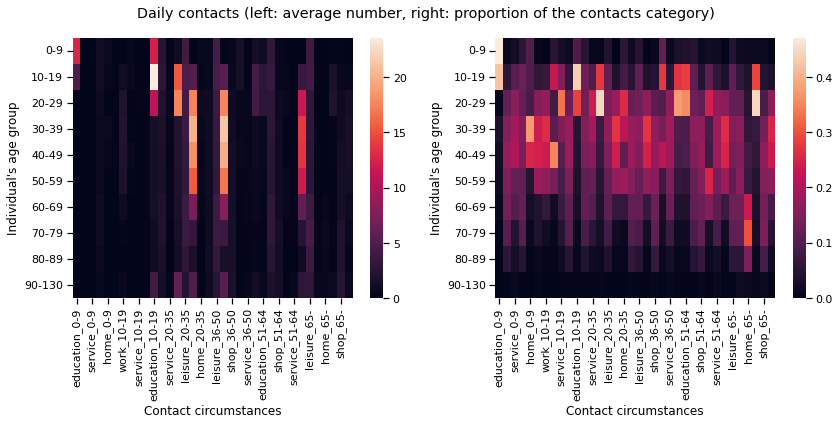

In [43]:
# Averages the contacts in every category over the age groups
avg_contacts_by_age = age_data.groupby('age').mean()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Sorts the columns so to have categories of same age group appear together
categories_age_groups = [col_name.split('_')[1] for col_name in avg_contacts_by_age.columns]
order = np.argsort(categories_age_groups)

sns.heatmap(avg_contacts_by_age.iloc[:, order], ax=ax[0])
ax[0].set_ylabel("Individual's age group")
ax[0].set_xlabel("Contact circumstances")

# Computes the proportion for each contact category of every age group 
contacts_proportions = age_data.groupby('age').sum() / age_data.iloc[:, 1:].sum(axis=0)

sns.heatmap(contacts_proportions.iloc[:, order], ax=ax[1])
ax[1].set_ylabel("Individual's age group")
ax[1].set_xlabel("Contact circumstances")

fig.suptitle("Daily contacts (left: average number, right: proportion of the contacts category)")
fig.tight_layout()
plt.savefig('../figures/contacts_age_heatmaps.png')
plt.show()

### Feature selection and regression
The socio-economic dataframe contains over 60 features. Many of them are most likely correlated, and thus it is naturally a good idea to isolate a smaller set of features to be used as predictors for the regression.  

#### Baseline model

In [44]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from matplotlib.gridspec import GridSpec

In [45]:
# Sets a random seed that should be used everywhere throughout the notebook,
# for the sake of reproducibility
_RANDOM_SEED_ = 42
# The usual train-test split. We shuffle the data as the order of the individuals
# might not be actually random.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=_RANDOM_SEED_)

In [46]:
def test_model(X, y, n_folds=5, model_builder=LinearRegression, use_scaler=True, verbose=False):
    """
    Given a set of features, optimizes a model 
        inputs --> c
    for every entry c in the contact matrix.
    :param X: 2D array / df, input data (predictors).
    :param y: 1D array / df, target data.
    :param n_folds: int, cross-validation folds to use.
    :param model_builder: function to call to build the model, which
        must implement fit() and score() (e.g. LinearRegression())
    :param use_scaler: bool, whether to scale the data before
        applying the model.
    """
    # Scales the input data if required
    if use_scaler:
        scaler = StandardScaler()
        scaler.fit(X)
        X = scaler.transform(X)
    
    # For each category (eg "leisure_0-19"), we estimate the model's performance
    # via cross-validation
    categories, score = [], []
    for category, contacts in y.items():
        if verbose:
            print("Evaluating model for category ", category)
        model = model_builder()
        cv_scores = cross_val_score(model, X, contacts, cv=n_folds)
        categories.append(category)
        score.append(cv_scores)
    return pd.DataFrame({
        'category': categories,
        'score': score
    }).explode('score')

Let's compare the performances of the linear regression (LR) and Random Forest regressor (RF), when *all* features are used:

In [47]:
max_rf_depth = 1
def build_rf():
    return RandomForestRegressor(max_depth=max_rf_depth)

# Compiles the cv scores for the linear regression
baseline_lr_scores = test_model(x_train, y_train, model_builder=LinearRegression)
# adds a column 'model' which is always 'LR', this will be used for plotting with seaborn
baseline_lr_scores['model'] = ['LR'] * baseline_lr_scores.shape[0]
# Same for the random forest
baseline_rf_scores = test_model(x_train, y_train, model_builder=build_rf)
baseline_rf_scores['model'] = [f'RF depth={max_rf_depth}'] * baseline_rf_scores.shape[0]
# Concats both models' results into a single DataFrame
baseline_scores = pd.concat([baseline_lr_scores, baseline_rf_scores], axis=0)

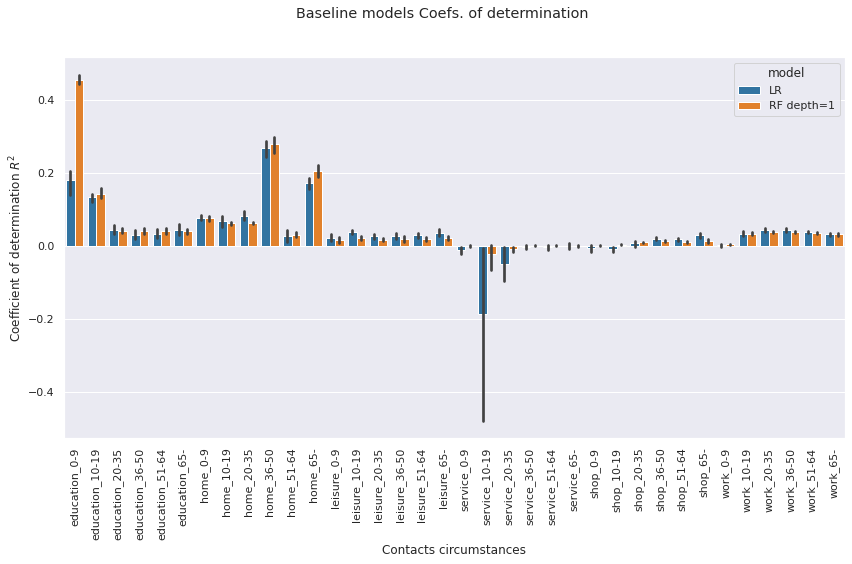

In [104]:
plt.figure(figsize=(14, 7))
with sns.axes_style("darkgrid"):
    sns.barplot(data=baseline_scores,x="category", y="score", hue="model")
    plt.xticks(rotation=90)
    plt.suptitle("Baseline models Coefs. of determination")
    plt.ylabel("Coefficient of determination $R^2$")
    plt.xlabel("Contacts circumstances")
plt.savefig('../figures/baseline_models_scores.png')

#### Features mutual correlation
Since we have so many features, many are probably inter-correlated. We might want to check the Pearson coefficient for each pair of feature. For that a heatmap is convenient:

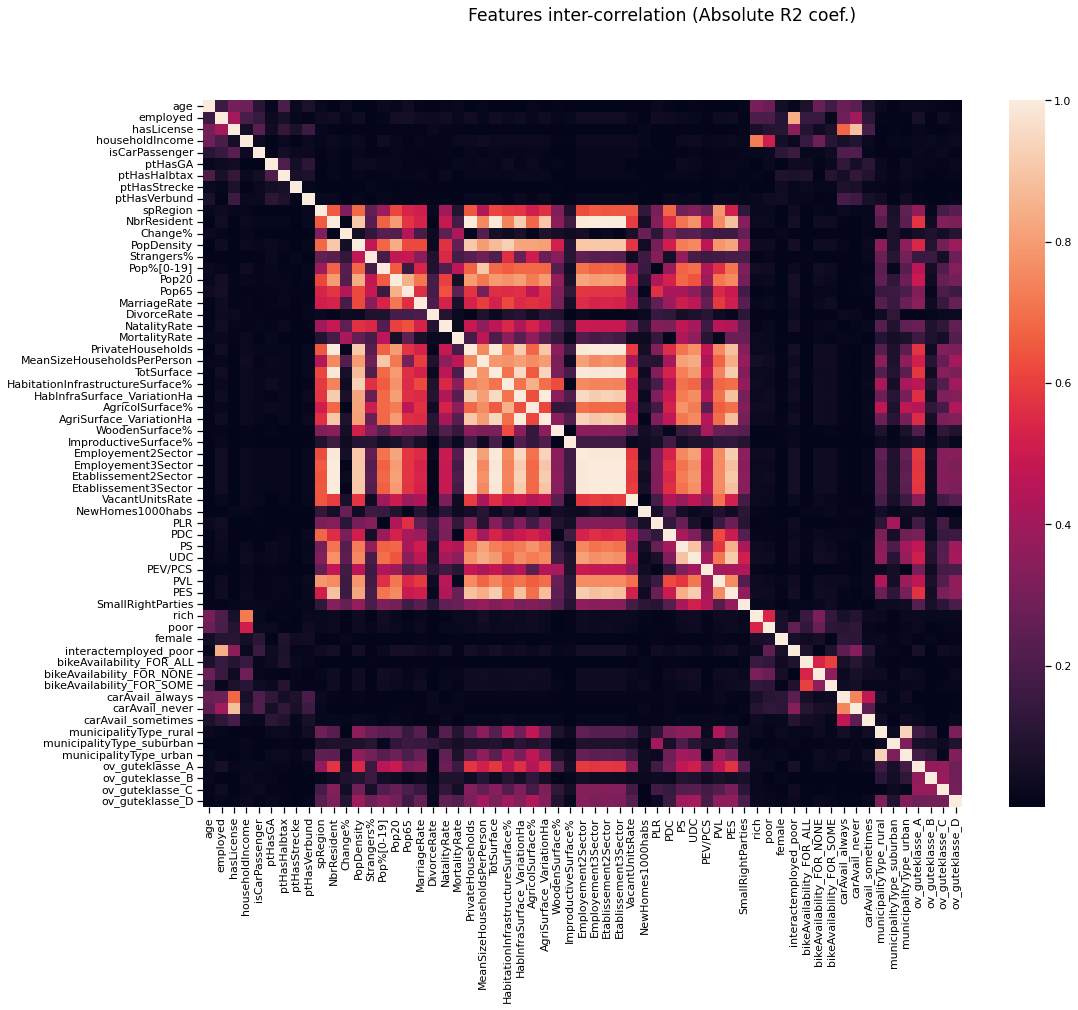

In [119]:
plt.figure(figsize=(17, 13))
plt.suptitle("Features inter-correlation (Absolute R2 coef.)", fontsize="x-large")
features_corr = X.corr()
sns.heatmap(np.abs(features_corr))
plt.savefig("../figures/inter_correlation.png")
plt.show()

#### Features-contacts correlations
We'll now look at the isolated correlation between each feature and the dependent variables.

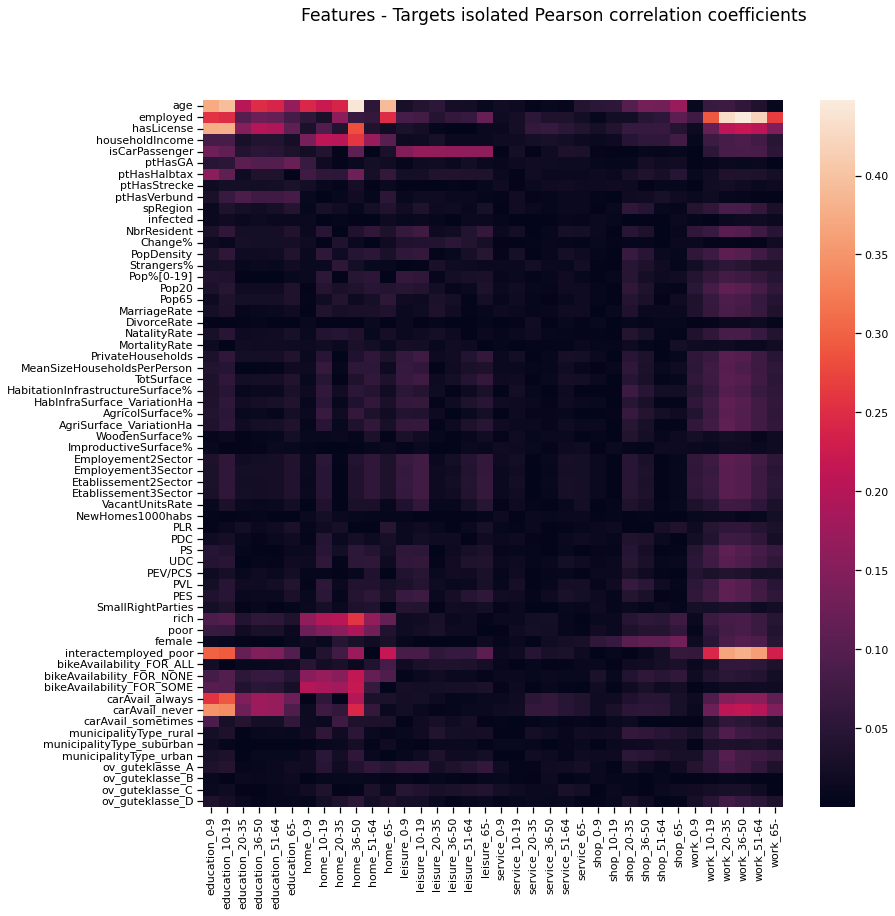

In [116]:
sep_correlations = {}
# For each dependent variable
for contact_cat, target in y_train.iteritems():
    sep_correlations[contact_cat] = []
    # For each feature (independent variable)
    for feature, feature_series in x_train.iteritems():
        # Compute the correlation between the independent and dependent variable
        sep_correlations[contact_cat].append(feature_series.corr(np.log(1 + target)))
sep_correlations = pd.DataFrame(sep_correlations, index=x_train.columns)

plt.figure(figsize=(13, 13))
plt.suptitle("Features - Targets isolated Pearson correlation coefficients", fontsize="x-large")
sns.heatmap(np.abs(sep_correlations))
plt.savefig("../figures/separataed_correlations.png")
plt.show()

#### Managing sparse values
For most predicted variables, the overwhelming majority of values are null:

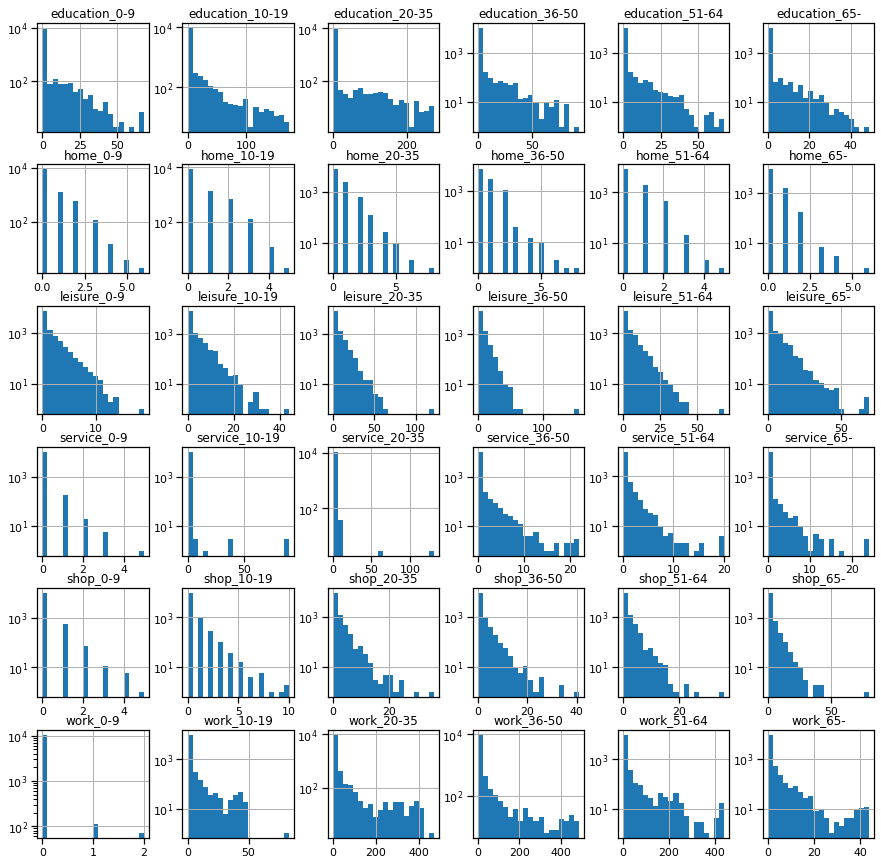

In [52]:
y_train.hist(bins=20, figsize=(15, 15), log=True)
plt.show()

This results in poor performances even for complex models such as deep random forests:

In [53]:
from sklearn.feature_selection import RFECV

In [54]:
def perform_rfe(x, y, model, use_scaler=False, step=3):
    """
    Optimizes the features for a specific model using
    Recursive Feature Elimination.
    """
    # Scales the input data if required
    if use_scaler:
        scaler = StandardScaler()
        scaler.fit(x)
        x = scaler.transform(x)
    
    # Finds the best combination of features to keep by recursively
    # discarding them
    rfecv = RFECV(estimator=model, cv=5, step=step).fit(x, y)
    return rfecv, rfecv.score(x, y)

In [103]:
## Currently skipped as it takes some time to run for no results
rfecv_base_rf, score_base_rf = perform_rfe(x_train, y_train, RandomForestRegressor(max_depth=10, random_state=42))
print(score_base_rf)

0.07559502379116603


In [ ]:
## Currently skipped as it takes some time to run for no results
rfecv_base_lr, score_base_lr = perform_rfe(x_train, y_train, Ridge(max_iter=1200, solver="saga", random_state=42), use_scaler=True)

In [102]:
print(score_base_lr)

0.05797527109560444


We only reach $R^2\approx 0.25$ with a max depth of 13.

Consequently, we might want to separate zero and nonzero-values. This requires to have the first model predict whether the value is zero (binary classification task) and then using the regression model.  

#### Classyfing zero values
We'll now try to solve the binary classification problem: Given a category of contacts (e.g. education0-19), can we predict for an individual
whether there will be any ?

In [ ]:
# Creates a binary vector whose value is 1 iff the original target is not zero
binary_y_train = (y_train > 0).astype(int)

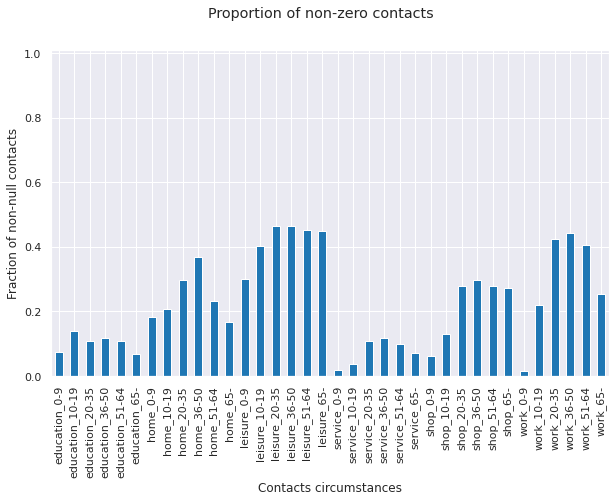

In [90]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(10, 6))
    # Plots the proportion of non-zero contacts for each condition
    (binary_y_train.sum() / y_train.shape[0]).plot.bar()
    plt.suptitle("Proportion of non-zero contacts")
    plt.ylim((0, 1.01))
    plt.ylabel("Fraction of non-null contacts")
    plt.xlabel("Contacts circumstances")
    plt.savefig('../figures/nonzero_proportions.png')
    plt.show()

##### With linear regression:

In [56]:
from sklearn.linear_model import LogisticRegression

In [57]:
## Runs a logistic regression to classify zero and nonzero contacts
## for each contacts category
log_regs_rfecvs, log_reg_scores = [], []
for contacts_category, target in binary_y_train.iteritems():
    print("Processing ", contacts_category)
    # Uses Recursive Feature Elimination with cross-validation
    # and mean/var standardization
    rfecv, score = perform_rfe(x_train, target,
                           LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l2'),
                          use_scaler=True, step=4)
    log_regs_rfecvs.append(rfecv)
    log_reg_scores.append(score)
log_reg_scores = pd.Series(data=log_reg_scores, index=y.columns)

Processing  education_0-9
Processing  education_10-19
Processing  education_20-35
Processing  education_36-50
Processing  education_51-64
Processing  education_65-
Processing  home_0-9
Processing  home_10-19
Processing  home_20-35
Processing  home_36-50
Processing  home_51-64
Processing  home_65-
Processing  leisure_0-9
Processing  leisure_10-19
Processing  leisure_20-35
Processing  leisure_36-50
Processing  leisure_51-64
Processing  leisure_65-
Processing  service_0-9
Processing  service_10-19
Processing  service_20-35
Processing  service_36-50
Processing  service_51-64
Processing  service_65-
Processing  shop_0-9
Processing  shop_10-19
Processing  shop_20-35
Processing  shop_36-50
Processing  shop_51-64
Processing  shop_65-
Processing  work_0-9
Processing  work_10-19
Processing  work_20-35
Processing  work_36-50
Processing  work_51-64
Processing  work_65-


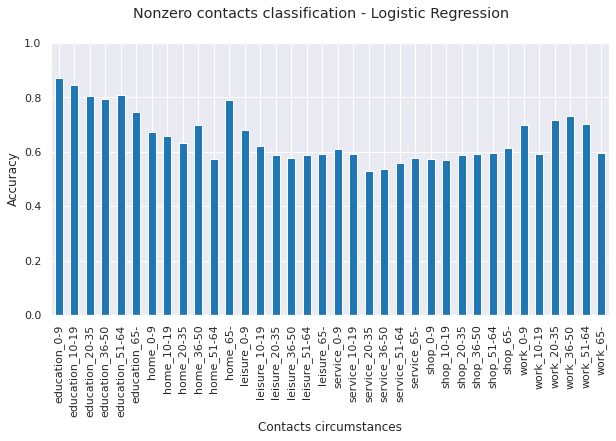

In [122]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    fig.suptitle('Nonzero contacts classification - Logistic Regression')
    log_reg_scores.plot.bar(ax=ax)
    ax.set_ylim((0, 1))
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Contacts circumstances')
    fig.savefig('../figures/nonzero_classif_lr.png')
    plt.show()

##### With Random Forests

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
## Runs a logistic regression to classify zero and nonzero contacts
## for each contacts category
rf_rfecvs, rf_scores = [], []
for contacts_category, target in binary_y_train.iteritems():
    print("Processing ", contacts_category)
    # Uses Recursive Feature Elimination with cross-validation
    # and mean/var standardization
    rfecv, score = perform_rfe(x_train, target,
                           RandomForestClassifier(max_depth=9),
                          use_scaler=True, step=5)
    rf_rfecvs.append(rfecv)
    rf_scores.append(score)
rf_scores = pd.Series(data=rf_scores, index=y.columns)

Processing  education_0-9
Processing  education_10-19
Processing  education_20-35
Processing  education_36-50
Processing  education_51-64
Processing  education_65-
Processing  home_0-9
Processing  home_10-19
Processing  home_20-35
Processing  home_36-50
Processing  home_51-64
Processing  home_65-
Processing  leisure_0-9
Processing  leisure_10-19
Processing  leisure_20-35
Processing  leisure_36-50
Processing  leisure_51-64
Processing  leisure_65-
Processing  service_0-9
Processing  service_10-19
Processing  service_20-35
Processing  service_36-50
Processing  service_51-64
Processing  service_65-
Processing  shop_0-9
Processing  shop_10-19
Processing  shop_20-35
Processing  shop_36-50
Processing  shop_51-64
Processing  shop_65-
Processing  work_0-9
Processing  work_10-19
Processing  work_20-35
Processing  work_36-50
Processing  work_51-64
Processing  work_65-


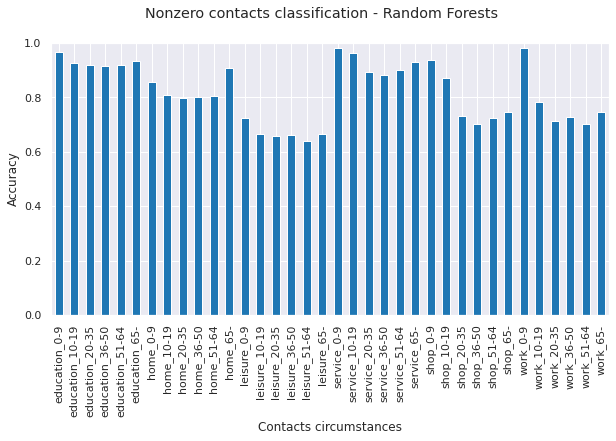

In [87]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    fig.suptitle('Nonzero contacts classification - Random Forests')
    rf_scores.plot.bar(ax=ax)
    ax.set_ylim((0, 1))
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Contacts circumstances')
    fig.savefig('../figures/nonzero_classif_rf.png')
    plt.show()

Let's check which features are most important:

In [63]:
# Will contain the feature importances for every contact category
# If a feature is not in the support of the RFECV (i.e. useless), its importance is 0.
feature_importances = pd.DataFrame(data=np.zeros((y_train.shape[1], x_train.shape[1])),
                                    index=y_train.columns, columns=x_train.columns)

for contact_cat, rfecv in zip(y.columns, rf_rfecvs):
    # For each contact category, get the RFECV object used for the category
    for feature, feature_in_support in zip(x_train.columns, rfecv.support_):
        # For each feature in x (e.g. age), get the support (boolean value indicating whether
        # the features was deemed useful for the classification).
        if feature_in_support:
            mask = rfecv.get_support()
            feature_importances.loc[contact_cat, mask] = rfecv.estimator_.feature_importances_

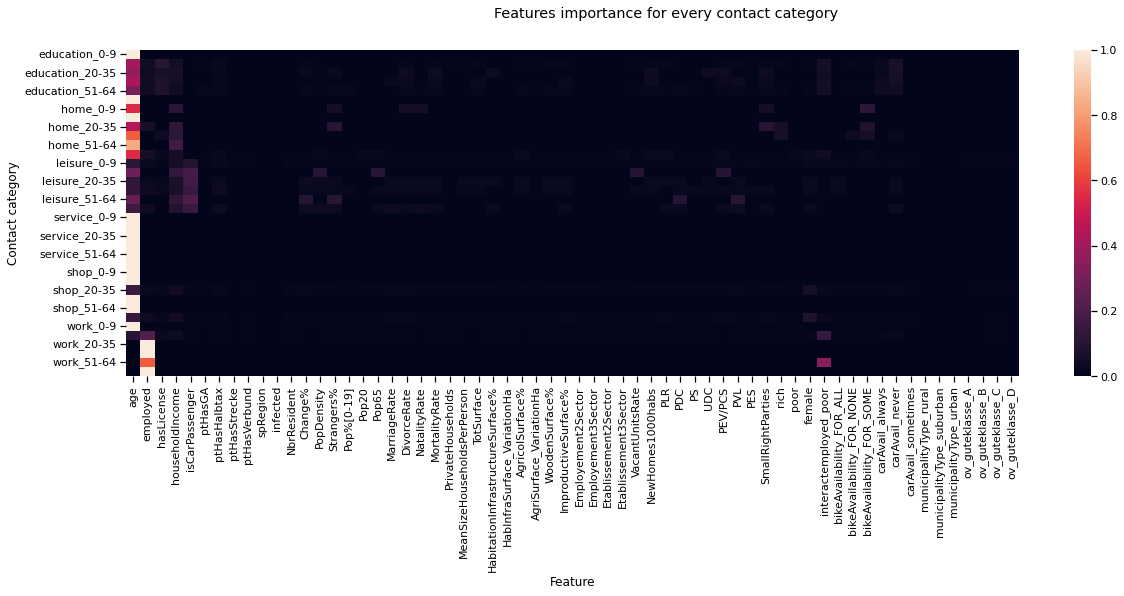

In [64]:
plt.figure(figsize=(20, 6))
sns.heatmap(feature_importances)
plt.ylabel("Contact category")
plt.xlabel("Feature")
plt.suptitle("Features importance for every contact category")
plt.show()

#### Nonzero contacts regression
The objective here is to predict the contact matrix entries *knowing that they are not null*.

##### With a linear regression

In [65]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [66]:
def get_nonzero_values(x, y):
    """
    Returns the rows of x and y where that of y
    is not 0.
    """
    nonzero_mask = y != 0
    return x[nonzero_mask], y[nonzero_mask]

In [67]:
## Fits a linear regression for each contact category
lin_reg_rfecvs, lin_reg_scores = [], []
for contacts_category, target in y_train.iteritems():
    # Filters the target to its nonzero entries only
    nonzero_x, target = get_nonzero_values(x_train, target)
    
    print("Processing ", contacts_category)
    # Uses Recursive Feature Elimination with cross-validation
    # and mean/var standardization
    rfecv, score = perform_rfe(nonzero_x, target,
                               Ridge(max_iter=1000),
                               use_scaler=True, step=1)
    lin_reg_rfecvs.append(rfecv)
    lin_reg_scores.append(score)
lin_reg_scores = pd.Series(data=lin_reg_scores, index=y.columns)

Processing  education_0-9
Processing  education_10-19
Processing  education_20-35
Processing  education_36-50
Processing  education_51-64
Processing  education_65-
Processing  home_0-9
Processing  home_10-19
Processing  home_20-35
Processing  home_36-50
Processing  home_51-64
Processing  home_65-
Processing  leisure_0-9
Processing  leisure_10-19
Processing  leisure_20-35
Processing  leisure_36-50
Processing  leisure_51-64
Processing  leisure_65-
Processing  service_0-9
Processing  service_10-19
Processing  service_20-35
Processing  service_36-50
Processing  service_51-64
Processing  service_65-
Processing  shop_0-9
Processing  shop_10-19
Processing  shop_20-35
Processing  shop_36-50
Processing  shop_51-64
Processing  shop_65-
Processing  work_0-9
Processing  work_10-19
Processing  work_20-35
Processing  work_36-50
Processing  work_51-64
Processing  work_65-


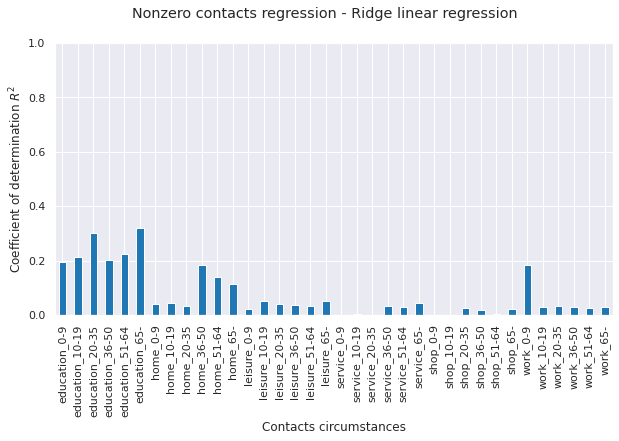

In [124]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    fig.suptitle('Nonzero contacts regression - Ridge linear regression')
    lin_reg_scores.plot.bar(ax=ax)
    ax.set_ylim((0, 1))
    ax.set_ylabel('Coefficient of determination $R^2$')
    ax.set_xlabel('Contacts circumstances')
    fig.savefig('../figures/nonzero_contacts_reg_lr.png')
    plt.show()

Let's have a look at the coefficients:

##### With Random Forests

In [105]:
## Fits a RF for each contact category
rf_reg_rfecvs, rf_reg_scores = [], []
for contacts_category, target in y_train.iteritems():
    # Filters the target to its nonzero entries only
    nonzero_x, target = get_nonzero_values(x_train, target)
    
    print("Processing ", contacts_category)
    # Uses Recursive Feature Elimination with cross-validation
    # and mean/var standardization
    rfecv, score = perform_rfe(nonzero_x, target,
                               RandomForestRegressor(max_depth=10),
                               use_scaler=False, step=4)
    rf_reg_rfecvs.append(rfecv)
    rf_reg_scores.append(score)
rf_reg_scores = pd.Series(data=rf_reg_scores, index=y.columns)

Processing  education_0-9
Processing  education_10-19
Processing  education_20-35
Processing  education_36-50
Processing  education_51-64
Processing  education_65-
Processing  home_0-9
Processing  home_10-19
Processing  home_20-35
Processing  home_36-50
Processing  home_51-64
Processing  home_65-
Processing  leisure_0-9
Processing  leisure_10-19
Processing  leisure_20-35
Processing  leisure_36-50
Processing  leisure_51-64
Processing  leisure_65-
Processing  service_0-9
Processing  service_10-19
Processing  service_20-35
Processing  service_36-50
Processing  service_51-64
Processing  service_65-
Processing  shop_0-9
Processing  shop_10-19
Processing  shop_20-35
Processing  shop_36-50
Processing  shop_51-64
Processing  shop_65-
Processing  work_0-9
Processing  work_10-19
Processing  work_20-35
Processing  work_36-50
Processing  work_51-64
Processing  work_65-


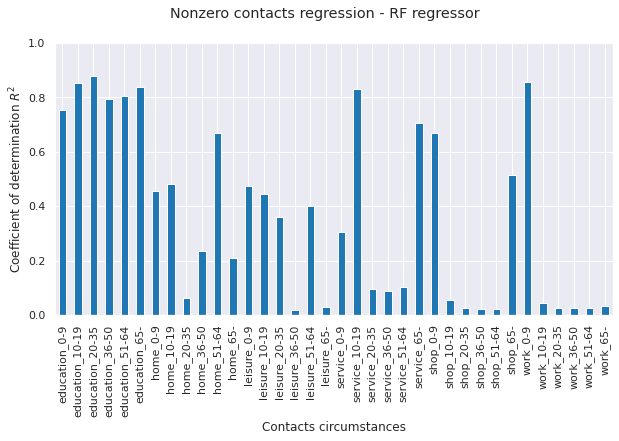

In [125]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    fig.suptitle('Nonzero contacts regression - RF regressor')
    rf_reg_scores.plot.bar(ax=ax)
    ax.set_ylim((0, 1))
    ax.set_ylabel('Coefficient of determination $R^2$')
    ax.set_xlabel('Contacts circumstances')
    fig.savefig('../figures/nonzero_contacts_reg_rf.png')
    plt.show()